W# Homework 6

## Modeling thermal effects in the battery Single Particle Model

### Suggested due date: before midnight on Wednesday, December 9.

For this assignment we are going to model the evolution of the temperature in our battery single particle model.  Our model will include the following phenomena:

- Ohmic (Joule) heating due to electronic current in cathode and anode solid phases
- Ohmic (Joule) heating due to ionic current in the electrolyte phase in the anode, cathode, and separator pores.
- Heating due to interface reactions in the anode and cathode (chemical and electric energy components)
- Conduction heat transfer between different components (anode, separator, cathode)
- Convection heat transfer at the battery boundaries (anode surface and cathode surface)
- Radiation heat transfer at the battery boundaries (anode surface and cathode surface)


The needed parameters have all been added to the battery `input` file, and calculated as needed in the battery `init` file.  I suggest you read through these files to understand what these parameters represent.

I have also done many of the preliminary calculations needed for your thermal model, in the `function` file.  What is left for you to do is to calculate the volumetric heat generation term, `Q_XX`, where `XX` represents a given phenomena from the bulleted list above.

For the single particle model, we have only three nodes (anode, electrolyte separator, and cathode).  For our thermal model, the, we track a single temperature for each.

You can go ahead and code all the `Q_XX` terms at one time, but we will add these phenomena one at a time, using a series of 'flags' that are set to either 0 or 1.  We will simulate a single charge curve at varying rates, to see the relative impact of each phenomenon, and how it depends on the charging rate of the battery.

Note that there is some internal inconsistency, here: Many of the phenomena above (such as ohmic losses in the electrodes and electrolyte) are not actually incorporated into our battery model (the electrolyte potential, for example, is assumed to be constant at zero).  We also have not incorporated any balance equations for species. For this reason, we will not pay any attention to the cell voltage.

Also, note that _many_ of these properties will vary as a funciton of temperature, in ways that would most certainly impact our temperature evolution.  Our work here will serve as a suitable first approximation, though.

Lastly, FWIW, the included python files demonstrate some new tricks that you might find useful for your project, such as passing 'keywords' when you call a function, which are then passed to the `main` model function.

# Working with this notebook.

1. You should not touch any of the code in the workbook.  All of your coding will be added to the `battery_spm` python files.
2. In this notebook, the only changes you will make are discussing the results.  Each discussion block is highlighted by <font color="red">**red, bold text**</font>.  **Please leave these markers in (do not delete them)**, so that I can easily find your discussion entries.
3. In your discussions, please refer to specific model equations or parameters from the battery spm code, to explain the trends that you see.  
4. If you are making changes to your python code which you feel are not being reflected in these results, you might was to click `Kernel->Restart` (or `Kernel->Restart and Clear Output` or `Kernel->Restart and Run All`) up at the top of this page.  I have added a bunch of code below (all the `importlib.reload` stuff, below), such that you shouldn't need to.  But just in case...
5. Finally, push all of your code (python files and this notebook) to your github repo and make a pull request, to submit.

Good luck!

# Battery cycling function

This function will call our battery model three times, for three different cycling rates (0.1 C, 1.0 C, and 10.0 C).  It will then plot the temperature profiles for the anode, separator, and cathode, as a function of time. Note that a charge at 0.1 C takes 100 times longer than one at 10 C.

In [12]:
# This will make it so that our notebook recognizes and reloads changes we have made in our python files:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import importlib
def plot_function(ax,sol,ptr,rate):
       
    from matplotlib import pyplot as plt
    ax.plot(sol.t, sol.y[ptr.T_an,:]-273)
    ax.plot(sol.t, sol.y[ptr.T_elyte,:]-273)
    ax.plot(sol.t, sol.y[ptr.T_ca,:]-273)
        
    ax.set_title('C-rate = '+str(rate)+'C',fontsize=14)
    return ax
    

def cycle_function(flags):
    from matplotlib import pyplot as plt

    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_01 = cycle(C_rate = 0.1, thermal_flags = flags)
    
    
    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_1 = cycle(C_rate = 1.1, thermal_flags = flags)


    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_10 = cycle(C_rate = 10, thermal_flags = flags)
    
    fig, axs = plt.subplots(1, 3, constrained_layout=False)
    fig.set_size_inches((12,3))
    axs[0] = plot_function(axs[0],solution_01,ptr,0.1)
    axs[1] = plot_function(axs[1],solution_1,ptr,1.0)
    axs[2] = plot_function(axs[2],solution_10,ptr,10)
    axs[1].legend(['Anode temperature','Separator temperature', 'Cathode temperature'],frameon=False)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axs[0].set_ylabel('T (C)',fontsize=14)
    
    plt.xlabel('Time (s)', fontsize=16)


# Okay, here is the actual assignment:
## Part I: Baseline: No thermal effects
We set all 'flag' values to zero, which sets all heat sources to zero.  Even if you have not added any code to the model, this part should run fine and give a constant T profile:

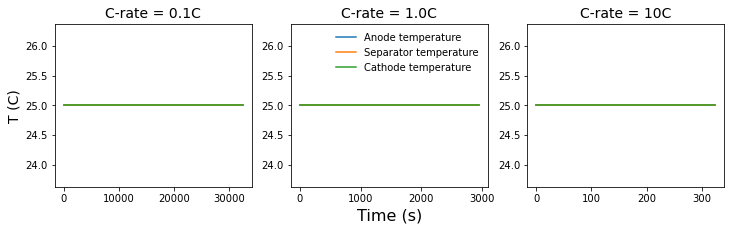

In [14]:
class thermal_flags:
    rxn = 0 # heat due to surface reactions
    ohm_el = 0 # ohmic/Joule heating from electron conduction
    ohm_io = 0 # ohmic/Joule heating from ion conduction
    cond = 0 # Heat transfer via thermal conduciton
    conv = 0 # Heat transfer via external convection
    rad = 0 # Heat tranfer via external radiation
    
cycle_function(thermal_flags)

## Part II: Heat released by reactions

The code already calculates $\dot{s}_{k,{\rm int}}$, the molar production of species due to interfacial reactions, and $e_k = h_k + z_kF\phi_k$, the energy of each species (note that an electron is a specie!).  Fill in the equation `Q_rxn`, the volumetric heating rate (W/m$^3$) due to these reactions.

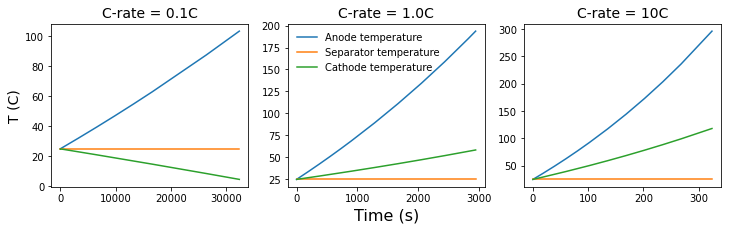

In [15]:
thermal_flags.rxn = 1 # This will stay at 1, from here on out.
cycle_function(thermal_flags)

### Discussion
You should see a dramatic change, relative to Part I.  Discuss these results.  Are they believable?  Would this be a good result for the battery?  Why do we see these trends, and what do you predict will happen as we add in more thermal effects

<font color='red'>[**Discuss right here**]</font>

There is a dramatic change compared to the case where there was no thermal effect. So, due to the exothermic nature of the surface reactions, the temperature of anode will go up. It will increase rapidly to a even higher temperature at higher cycling rate due to the higher current density. The temperature of the electrolyte separator remains constant due to the lack of reactions happening in that phase. The results are not realistic since only heat production meachanisms (only surface reactions here) are considered here and not the meachanisms that carries the generated heat out including conduction and convection.

You should also see the temperature trend for the cathode switch, when going from 0.1C to 1.0C


<font color='red'>[**Why is this?  Refer to the model equations that you added, to explain.**]</font>

I am not sure though why the cathode temperature goes down at lower cyclic rate!

## Part III: Ohmic/Joule Heating

### a. Electron conduction

Add in the equation for the volumetric heating rate due to electron conduction, `Q_ohm_el`.  The code already has calculated `pars.R_el_electrode` for each electrode phase (`pars.R_el_an` and `pars.R_el_ca`), which are the _resistivities_ $\rho_{\rm el}$ (units: $\Omega-m$).

Because we have a single volume for each electrode, we know _a priori_ the electronic current in each electrode (hint: no calculations are needed, for both $i_{\rm elec}$ in the electrodes and $i_{\rm io}$ in the electrolyte phase).

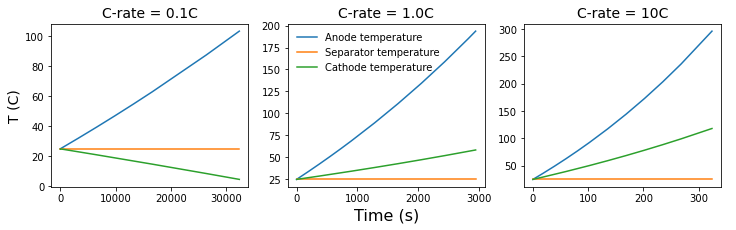

In [5]:
thermal_flags.ohm_el = 1
cycle_function(thermal_flags)

### Discussion:

Do you see any significant changes, relative to Part II?  You should not.  Why?  What does this say about electronic conduction, and which input parameter determined this?

<font color='red'>[**Discuss here**]</font>

No significant difference is seen. Perhaps this can be justified due to the fact that the anode and cathode materials are decent electronic conductors that no heat generation is observed through electronic conduction.

### b. Ion conduction

Repeat part 1, but for Joule heating due to ion conduction, `Q_ohm_io`.  Note that there is ion conduction in the two electrodes _and_ in the electrolyte separator.

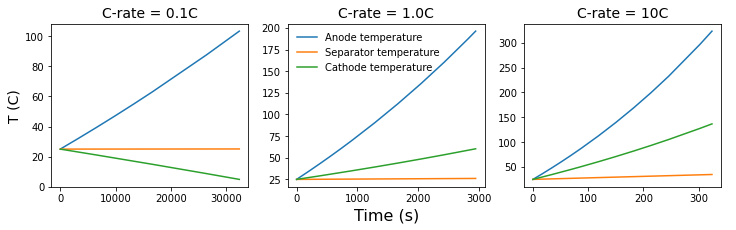

In [16]:
thermal_flags.ohm_io = 1
cycle_function(thermal_flags)

### Discussion:

Do you see any significant changes, relative to Parts II and IIa?  Look closely - there should be some minor changes.  Why?  What does this say about ion conduction, and which input parameter determined this?

Is there a larger impact for some C-rates, compared to others?  Why?

<font color='red'>[**Discuss here**]</font>
Only at C_rate=10C a slight increase in the temperature can be seen. Higher cyclic rate pushes higher amount of ions through all three phases that causes slight temperature increase due to the ionic conduction, even thoough higher ionic conduction prevents temperature rise in lower cyclic rates. Also, very subtle temperature rise for the separator can be seen here as well.

## Part IV: Thermal conduction

Now implement thermal conductivity equations.  This is done in two steps, in the code:

1. Calculate the conduction heat transfer fluxes `Q_cond_an` and `Q_cond_ca`:
- From the anode to the separator: $\dot{Q}^{\prime\prime}_{\rm cond,an} = -\lambda_avg\nabla T$ (W/m$^2$)
- From the anode to the separator: $\dot{Q}^{\prime\prime}_{\rm cond,ca} = -\lambda_avg\nabla T$ (W/m$^2$)

For both calculations, the volume-weighted average thermal conductivity `lambda` at the relevant electrode/separator interface and the distance between the two volume centers `dyInv` are already calculated for you. 

2. Once the relevant heat fluxes are calculated, calculate the relevant volumetric heat generation terms due to conduction `Q_cond` for the anode, separator, and cathode.

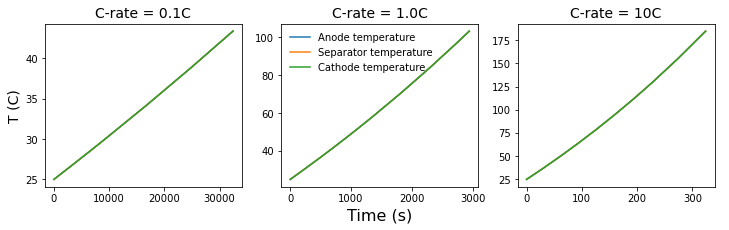

In [20]:
thermal_flags.cond = 1
cycle_function(thermal_flags)

### Discussion:

There should once again be a significant change, relative to Part III. You should see that the anode, separator, and cathode temperatures have all collapsed onto one another. Why is that?  What properties in our inputs lead to this behavior?

What happens to the overall magnitude of the temperatures, relative to part III?  Does this make sense, based on our cell geometry?  What does it say about the "thermal mass" of each component?

Do you thnk these results are accurate?  Why or why not?  Would _this_ be a good temperature profile, for a battery (i.e. would we want our battery to experience these temperatures?)

<font color='red'>[**Discuss here**]</font>

The temperatures go down significantly, since the conduction carries the heat away and prevents the battery from the heat buildup. This means the battery model is getting more realistic compared to the previous models where there was no heat conduction. All the temperature collapse onto one another since a volume weighted thermal conductivities are used to calculate the conduction heat values. The conductivities are also chosen in a way that cancels out the differences. It could be realistic since anode, separator and the cathode are in close contact with each other.
This is still not a good temperature profile for a battery, since the temperatures are high. The conducted heat must be carried away by the means of radiation/convection later on.

## Part V: Radiation heat transfer

Now implement radiation heat transfer at the battery surface (anode and cathode bondaries).
\begin{equation}
    \dot{Q}^{\prime\prime}_{\rm rad} = \sigma\epsilon\left(T^4_{\rm amb} - T^4_{\rm surf}\right)\frac{A}{V}
\end{equation}
The model code has already defined `sigma`, the Stefan-Boltzmann constant, plus `pars.emmissivity`, the surface emmissivity ($\epsilon$), the ambient temperature `pars.T_amb`, and `pars.A_ext`, the surface area per unit volume for both electrodes, (i.e. $\frac{A}{V}$ in the equation above. Tthe same value is used for both electrodes).

Calculate `Q_rad`, the total heat transferred to each component per unit volume.


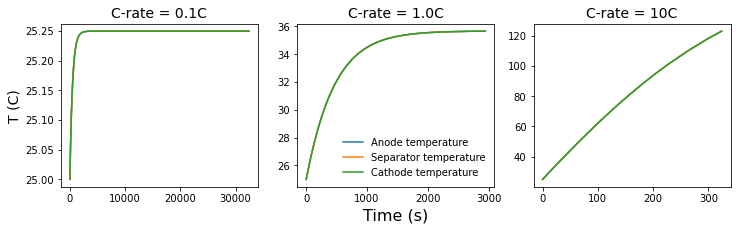

In [21]:
thermal_flags.rad = 1
cycle_function(thermal_flags)

### Discussion 

<font color='red'>[**Discuss the results here**]</font>

What do you notice?  Is this believable?  Why do some C-rates reach a steady-state value, and some do not?

For those that do reach a steady-state temperature, what determines the steady state value?  What processes are being balanced, at steady state?

Now that the generated heat is carried out to the boundaries via conduction, it is released to the ambient via radiation. At lower cyclic rates, not only the reached steady state temperature is lower, but the transition time is also lower. At lower cyclic rates, the electrochemical reactions are slower due to the smaller current density. So, the generated heat is rapidly carried away by radiation, such that it comes to the point where the generated heat and the released heat becomes equal, at which a steady state temperature is seen. This phenomena does not happen that fast for the case with higher cyclic rate where the heat generated by electrochemical reactions overcomes the heat released through the boundaries via radiation. Still, the temperatures are highspecially for greater cyclic rates.

## Part VI: Convection heat transfer.

Now we'll turn radiation back off, and instead model convective heat transfer at the boundary.  Similar to above, calculate a `Q_rad` value: 
\begin{equation}
    \dot{Q}^{\prime\prime}_{\rm conv} = h_{\rm conv}\left(T_{\rm amb} - T_{\rm surf}\right)\frac{A}{V}
\end{equation}
where `pars.h_conv` is already defined for you (same value for anode and cathode).

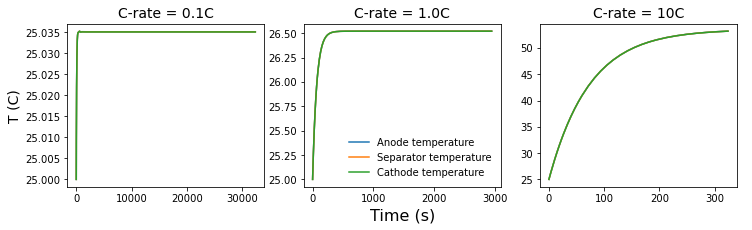

In [22]:
thermal_flags.rad = 0
thermal_flags.conv = 1
cycle_function(thermal_flags)

### Discussion 

<font color='red'>[**Discuss the results here**]</font>

What do you notice?  What does this say about the relative influence of convection vs. radiation heat transfer, for the given input parameters?

Higher decrease in temperature is seen here due to the mechanism called convection. It seems that the convection carries away more heat compared to the radiation. This is justified by the fact that very large temperature difference between the system and the surronding is required for a high radiation heat transfer compared to the convection where the boundary layer development enhances the heat transfer rate.

## Part VII: Putting it all together

Okay, finally, incorporate all thermal effects:

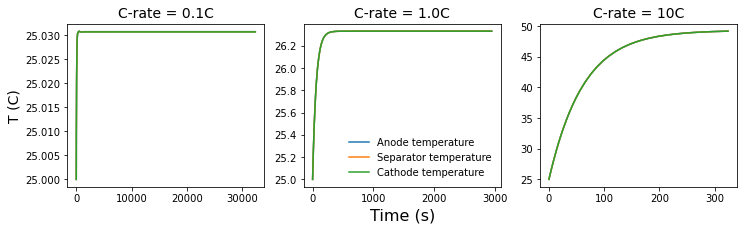

In [23]:
thermal_flags.rad = 1
cycle_function(thermal_flags)

### Discussion

Now that we have all thermal effects incorporated, answer a few final questions:

1.  Would _this_ be a good temperature for our battery?

<font color='red'>[**Discuss here**]</font>

It seems reasonable, since the steady state temperature at a very high cyclic rate reaches almost 50C which is acceptable.

2.  If we incorporated temperature dependent parameters, how do you think our results would change?  Be specific: which parameters would change, and how would this impact our various thermal terms (i.e. conduction, ohmic, etc...)

Note: For some parameters (ahem, _species thermo_), we don't really have enough info to say exactly how the results would change.  Saying "I don't know, but it would depend on X, Y, Z" is perfectly fine.

<font color='red'>[**Discuss here**]</font>

The convective heat transfer coefficient might go up, considering free convection assumption around the battery where typically there is no forced air (convective heat transfer depends on Nusselt number which depends on Rayleigh number where the temperature difference between the system and surronding is included). This would increase convective heat transfer that then reduces the steady state temperature.
Moreover, the thermal conductivity of a material increases at higher temperatures which facilitates the thermal conduction that carries heat away. So, the steady state temperature would go down, even though the electronic conductivity would go down. But, as it was seen above, the heat generation fue to the electronic and ionic conductivities are not significant.

3. Discuss the influence of C-rate on our battery's thermal response.  Is the relationship between C-rate and max temperature linear? (hint: it is not) Why do you think this is?  What about the dynamic response?  With increasing C-rate, we see that the battery takes _a greater fraction of the total charge time_ to reach steady state. Why is that?  Is the dynamic response actually slower at higher C-rate, or is there something else goign on?

<font color='red'>[**Discuss here**]</font>

At higher cyclic rate, higher current density is pulled out that proportionally takes longer time to reach stady state condition. But, again it is proportional, since the whole charging time is 100 times faster at C_rate of 10 comppared to 1 C. So, the dynamic response of the case with higher cyclic rate is faster.
The relationtion between C_rate and max temperature is not linear mainly because the heat generated via surface reaction exponentially changes with current density (or C_rate).

# Thanks for a really great semester.  You've all worked incredibly hard, under difficult circumstances, and I've been impressed by all that you've learned, and sincerely enjoyed getting to spend Tuesdays and Thursdays with you!

## Please feel free to stay in touch, after the semester is over.  I'll leave the Slack workspace open, so long as people are using it.

## If there is any way I can be of use/assistance, either during your time at Mines or beyond, don't hesitate to reach out!  Slack is best, so long as the workspace remains open.